# Import Packages

In [1]:
from __future__ import print_function

import warnings
warnings.filterwarnings("ignore")

import gensim

#For Feature Engineering
import re
import random
from scipy import sparse as sp
import string
import nltk
from nltk.tokenize import wordpunct_tokenize,TweetTokenizer
from sklearn.impute import KNNImputer

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from time import time
from sklearn.model_selection import StratifiedKFold


import tensorflow as tf
import random as rn
import os
from tensorflow.keras import optimizers,backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.layers import Input,Dense, Dropout, Embedding,Conv1D,GlobalMaxPooling1D,Concatenate,GaussianNoise,LSTM,BatchNormalization,Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers

# Function Definition

In [2]:
def MLP_model(model,df_train,df_test,sentence_vector=False):
  #Filter Data
  if not sentence_vector:
    #Feature Engineering
    df_train,df_test=PMI(df_train,df_test)
    for gram in [1,2,3,4]:
      df_train,df_test=rf_ngram(df_train,df_test,gram=gram)

    df_train=df_train.drop(['cashtag','spans','text','clean_text','base_text','source'],1)
    df_test=df_test.drop(['cashtag','spans','text','clean_text','base_text','source'],1)
  else:
    df_train=W2V_sentence_embedding(df_train)
    df_test=W2V_sentence_embedding(df_test)
    df_train=df_train.drop('source',1)
    df_test=df_test.drop('source',1)

  #Split data into dependent and independent variable
  X_train=df_train.drop(['sentiment score'],1)
  X_test=df_test.drop(['sentiment score'],1)
  y_train=df_train['sentiment score']
  y_test=df_test['sentiment score']

  #Impute Missing Testues
  imputer = KNNImputer(n_neighbors=3)
  X_train=pd.DataFrame(imputer.fit_transform(X_train))
  X_test=pd.DataFrame(imputer.fit_transform(X_test))

  #Predict 
  y_pred=model.predict(X_test,batch_size=32)
  y_pred=pd.Series(y_pred.tolist()).apply(lambda x: x[0])
  print('Val Cosine Similarity:{} '.format(cosine_similarity(y_test,y_pred)))
  return y_pred

def model_CNN_LSTM(model,df_train,df_test):
  X_train=df_train['clean_text'].tolist()
  y_train=np.array(df_train['sentiment score'])
  X_test=df_test['clean_text'].tolist()
  y_test=np.array(df_test['sentiment score'])

  # prepare tokenizer
  t = Tokenizer()
  t.fit_on_texts(X_train)
  X_train = t.texts_to_sequences(X_train)
  X_test = t.texts_to_sequences(X_test)

  # Adding 1 because of reserved 0 index
  vocab_size = len(t.word_index) + 1

  X_train = pad_sequences(X_train, padding='post', maxlen=50)
  X_test = pad_sequences(X_test, padding='post', maxlen=50)

  #Predict 
  y_pred=model.predict(X_test,batch_size=32)
  y_pred=pd.Series(y_pred.tolist()).apply(lambda x: x[0])
  print('Val Cosine Similarity:{} '.format(cosine_similarity(y_test,y_pred)))
  return y_pred

def grid_model_ensemble(df_train,df_test,hidden_nodes,dropout,l2_regularizer,act,optimizer,epochs,batch_size=16):
  X_train=df_train.drop(columns=['source','sentiment score'])
  y_train=df_train['sentiment score']
  X_test=df_test.drop(columns=['source','sentiment score'])
  y_test=df_test['sentiment score']

  #Define MLP Ensemble
  model = Sequential()
  if dropout==0:
    model.add(Dense(hidden_nodes,input_shape=(X_train.shape[1],),
                    kernel_regularizer=regularizers.l2(l2_regularizer),activity_regularizer=regularizers.l2(l2_regularizer)))
  else:
    model.add(Dropout(dropout, input_shape=(X_train.shape[1],)))
    model.add(Dense(hidden_nodes,kernel_regularizer=regularizers.l2(l2_regularizer),activity_regularizer=regularizers.l2(l2_regularizer)))
  model.add(Activation(act))
  model.add(Dense(1,activation='tanh'))
  
  model.compile(loss='MSE',optimizer=optimizer,metrics=['cosine_proximity']) 
  history=model.fit(X_train, y_train,epochs=epochs,batch_size=batch_size,validation_data=(X_test,y_test),verbose=False)
  plt.figure(figsize=(6,6))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  pred_test=model.predict(X_test)
  pred_test=pd.Series(pred_test.tolist()).apply(lambda x: x[0])
  cos=cosine_similarity(y_test,pred_test)
  print('Val Cosine Similarity: {}'.format(cos))

def model_ensemble(df_train,hidden_nodes,dropout,l2_regularizer,act,optimizer,epochs,batch_size=16):
  X_train=df_train.drop(columns=['source','sentiment score'])
  y_train=df_train['sentiment score']

  #Define MLP Ensemble
  model = Sequential()
  if dropout==0:
    model.add(Dense(hidden_nodes,input_shape=(X_train.shape[1],),
                    kernel_regularizer=regularizers.l2(l2_regularizer),activity_regularizer=regularizers.l2(l2_regularizer)))
  else:
    model.add(Dropout(dropout, input_shape=(X_train.shape[1],)))
    model.add(Dense(hidden_nodes,kernel_regularizer=regularizers.l2(l2_regularizer),activity_regularizer=regularizers.l2(l2_regularizer)))
  model.add(Activation(act))
  model.add(Dense(1,activation='tanh'))
  
  model.compile(loss='MSE',optimizer=optimizer,metrics=['cosine_proximity']) 
  history=model.fit(X_train, y_train,epochs=epochs,batch_size=batch_size,verbose=False)
  return model

def cosine_similarity(a,b):
  return np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))

def tokenize(sentence):
  '''
  tokenize input sentence into token
  '''
  return (nltk.regexp_tokenize(sentence, pattern=r"\s|[\.,;]\D", gaps=True))

def n_grams_handled(sentence):
  '''
  Filter before generate n-gram
  '''
  try:
    tk=TweetTokenizer()
    cashtag_pat=r'\$[^\s]+'
    hashtag_pat=r'#([^\s]+)'
    word_number_pat=r'\w*\d\w*'
  
    #Remove word which has length < 2
    stripped=' '.join([word for word in sentence.split() if len(word)>=2])
  
    #Remove hashtag
    hashtag_handled= re.sub(hashtag_pat,"", stripped)
  
    #Remove cashtag
    cashtag_handled= re.sub(cashtag_pat,"", hashtag_handled)
    
    #Remove word with number
    number_handled= re.sub(word_number_pat,"", cashtag_handled)
  
    #Remove unnecesary white spaces
    words = tk.tokenize(number_handled)
    words = [x for x in words if x not in string.punctuation]
    clean_sentence=(" ".join(words)).strip()
    return  clean_sentence
  except:
    return sentence

def rf_ngram(df_train,df_test,gram): 
  '''
  create rf-ngram
  '''
  def sentence_sparse(sentence,gram,rf_ngram,sparse_rf_ngram):
    #Initiate Linke List Sparse Matrix
    zero_sparse=sp.lil_matrix( (1,len(rf_ngram)), dtype=float)
    #Assign Value of rf_ngram to each word in sentence
    splitted_text=tokenize(n_grams_handled(sentence))
    #Unigram
    if gram==1:
      for word in splitted_text:
        if word in rf_ngram.index:
          zero_sparse[0,rf_ngram.index.get_loc(word)]+=sparse_rf_ngram[0,rf_ngram.index.get_loc(word)]
      #Convert LinkedList Sparse Matrix into CSR Sparse Matrix
      sparse=zero_sparse.tocsr()
    #Bigram
    elif gram==2:
      bigram=lambda x: splitted_text[x]+' '+splitted_text[x+1]
      it_2_gram=range(len(splitted_text)-1)
      for i in it_2_gram:
        if bigram(i) in rf_ngram.index:
          zero_sparse[0,rf_ngram.index.get_loc(bigram(i))]+=sparse_rf_ngram[0,rf_ngram.index.get_loc(bigram(i))]
      #Convert LinkedList Sparse Matrix into CSR Sparse Matrix
      sparse=zero_sparse.tocsr()
    #Trigram
    elif gram==3:
      trigram=lambda x: splitted_text[x]+' '+splitted_text[x+1]+' '+splitted_text[x+2]
      it_3_gram=range(len(splitted_text)-2)
      for i in it_3_gram:
        if trigram(i) in rf_ngram.index:
          zero_sparse[0,rf_ngram.index.get_loc(trigram(i))]+=sparse_rf_ngram[0,rf_ngram.index.get_loc(trigram(i))]
      #Convert LinkedList Sparse Matrix into CSR Sparse Matrix
      sparse=zero_sparse.tocsr()
    #4grams
    elif gram==4:
      fourgram=lambda x: splitted_text[x]+' '+splitted_text[x+1]+' '+splitted_text[x+2]+' '+splitted_text[x+3]
      it_4_gram=range(len(splitted_text)-3)
      for i in it_4_gram:
        if fourgram(i) in rf_ngram.index:
          zero_sparse[0,rf_ngram.index.get_loc(fourgram(i))]+=sparse_rf_ngram[0,rf_ngram.index.get_loc(fourgram(i))]
      #Convert LinkedList Sparse Matrix into CSR Sparse Matrix
      sparse=zero_sparse.tocsr()
    return(sparse)

  BOW_df= pd.DataFrame(columns=['pos','neutral','neg'])
  words_set = set()
  
  #Creating the rf_ngram dictionary of words
  it=range(len(df_train))
  for i in it:
    score=df_train.loc[i,'sentiment score']
    if score>0:
      score='pos'
    elif score<0:
      score='neg'
    else:
      score='neutral'
    try:
      text=df_train.loc[i,'clean_text']
      cleaned_text=n_grams_handled(text)
      splitted_text=tokenize(cleaned_text)
      if gram==1:
        for word in splitted_text:
          if word not in words_set:#check if this word already counted or not in the full corpus
            words_set.add(word)
            BOW_df.loc[word] = [0,0,0]
            BOW_df.loc[word,score]+=1
          else:
            BOW_df.loc[word,score]+=1
      elif gram==2:
        it_2_gram=range(len(splitted_text)-1)
        bigram=lambda x: splitted_text[x]+' '+splitted_text[x+1]
        for i in it_2_gram:
          if bigram(i) not in words_set:
            words_set.add(bigram(i))
            BOW_df.loc[bigram(i)] = [0,0,0]
            BOW_df.loc[bigram(i),score]+=1
          else:
            BOW_df.loc[bigram(i),score]+=1
      elif gram==3:
        it_3_gram=range(len(splitted_text)-2)
        trigram=lambda x: splitted_text[x]+' '+splitted_text[x+1]+' '+splitted_text[x+2]
        for i in it_3_gram:
          if trigram(i) not in words_set:
            words_set.add(trigram(i))
            BOW_df.loc[trigram(i)] = [0,0,0]
            BOW_df.loc[trigram(i),score]+=1
          else:
            BOW_df.loc[trigram(i),score]+=1
      elif gram==4:
        it_4_gram=range(len(splitted_text)-3)
        fourgram=lambda x: splitted_text[x]+' '+splitted_text[x+1]+' '+splitted_text[x+2]+' '+splitted_text[x+3]
        for i in it_4_gram:
          if fourgram(i) not in words_set:
            words_set.add(fourgram(i))
            BOW_df.loc[fourgram(i)] = [0,0,0]
            BOW_df.loc[fourgram(i),score]+=1
          else:
            BOW_df.loc[fourgram(i),score]+=1 
    except:
      None
  #Calculate rf_ngram for each word
  series_1=pd.Series([1 for x in range(len(BOW_df))])
  series_1.index=BOW_df.index
  series_2=pd.Series([2 for x in range(len(BOW_df))])
  series_2.index=BOW_df.index
  frac_1=np.log(series_2+(BOW_df['pos']/pd.concat([series_1,BOW_df['neg']],1).max(axis=1)))
  frac_2=np.log(series_2+(BOW_df['neg']/pd.concat([series_1,BOW_df['pos']],1).max(axis=1)))
  rf_ngram_series= pd.concat([frac_1,frac_2],1).max(axis=1)
  sparse_rf_ngram=sp.csr_matrix(rf_ngram_series)

  def rf_ngram_calculate(x):
    lst=[i for i in sentence_sparse(x,gram,rf_ngram_series,sparse_rf_ngram).toarray()[0].tolist() if i!=0]
    if type(x)!=str:
      return(np.nan)
    else:
      if len(lst)>0:
        return(np.mean(lst))
      else:
        return(np.nan)

  rf_ngram_avg_list_train=df_train['clean_text'].apply(lambda x: rf_ngram_calculate(x))
  rf_ngram_avg_list_test=df_test['clean_text'].apply(lambda x: rf_ngram_calculate(x))

  df_train['Avg_rf_'+str(gram)+'-grams']= rf_ngram_avg_list_train
  df_test['Avg_rf_'+str(gram)+'-grams']= rf_ngram_avg_list_test

  return(df_train,df_test)

def PMI(df_train,df_test): 
  '''
  create PMI variable
  '''
  BOW_df= pd.DataFrame(columns=['pos','neutral','neg'])
  words_set = set()
  
  #Creating the dictionary of words
  it=range(len(df_train))
  for i in it:
    score=df_train.loc[i,'sentiment score']
    if score>0:
      score='pos'
    elif score<0:
      score='neg'
    else:
      score='neutral'
    try:
      text=df_train.loc[i,'clean_text']
      cleaned_text=n_grams_handled(text)
      splitted_text=tokenize(cleaned_text)
      for word in splitted_text:
        if word not in words_set:#check if this word already counted or not in the full corpus
          words_set.add(word)
          BOW_df.loc[word] = [0,0,0]
          BOW_df.loc[word,score]+=1
        else:
          BOW_df.loc[word,score]+=1
    except:
      None
    
  N=len(BOW_df) #Number of unique tokens in the corpus
  pos_N=len(BOW_df[BOW_df.pos!=0]) #Number of unique positive tokens in the corpus
  neg_N=len(BOW_df[BOW_df.neg!=0]) #Number of unique positive tokens in the corpus
  total=BOW_df.sum().sum() #Number of tokens in the corpus
  pos_total=BOW_df.sum()['pos'] #Number of tokens in the positive corpus
  neg_total=BOW_df.sum()['neg'] #Number of tokens in the negative corpus
  PMI_df=pd.DataFrame(columns=['freq_word','freq_word_pos','freq_word_neg'])
  PMI_df['freq_word']=pd.Series(BOW_df.index).apply(lambda x: (BOW_df.loc[x,'pos']+BOW_df.loc[x,'neutral']+BOW_df.loc[x,'neg'])/total)
  PMI_df['freq_word_pos']=pd.Series(BOW_df.index).apply(lambda x: BOW_df.loc[x,'pos']/pos_total) #Freq of word w in positive text
  PMI_df['freq_word_neg']=pd.Series(BOW_df.index).apply(lambda x: BOW_df.loc[x,'neg']/neg_total) #Freq of word w in negative text
  PMI_df.index=BOW_df.index
  
  #Calculate PMI for each word
  PMI_df['PMI_pos']=np.log2(1+((PMI_df['freq_word_pos']*N)/(PMI_df['freq_word']*pos_N)))
  PMI_df['PMI_neg']=np.log2(1+((PMI_df['freq_word_neg']*N)/(PMI_df['freq_word']*neg_N)))
  PMI_df['PMI']=PMI_df['PMI_pos']-PMI_df['PMI_neg']
 
  def PMI_calculate(x):
    lst=[PMI_df.loc[i,'PMI'] for i in tokenize(n_grams_handled(x)) if i in PMI_df.index]
    if type(x)!=str:
      return(np.nan)
    else:
      if len(lst)>0:
        return(np.mean(lst))
      else:
        return(np.nan)

  PMI_avg_list_train=df_train['clean_text'].apply(lambda x: PMI_calculate(x))
  PMI_avg_list_test=df_test['clean_text'].apply(lambda x: PMI_calculate(x))
  
  df_train['PMI_score']=PMI_avg_list_train
  df_test['PMI_score']=PMI_avg_list_test

  return(df_train,df_test)

def W2V_sentence_embedding(df,span=False):
  '''
  return dataframe for W2V sentence embedding
  '''
  if not span:
    column='clean_text'
  else:
    column='spans'
    
  zero=np.array([float(0) for i in range(300)])
  nan=np.array([np.nan for i in range(300)])
  vec_W2V=lambda x: model_w2v[x] if x in model_w2v else zero
  W2V_avg=df[column].apply(lambda sent: pd.Series(tokenize(sent)).apply(lambda x: vec_W2V(x)).mean() if type(sent)==str else nan)
  
  W2V_df=pd.DataFrame(dict(zip(W2V_avg.index, W2V_avg.values))).T
  W2V_df['source']=df['source']
  W2V_df['sentiment score']=df['sentiment score']
  col=['x'+str(i) for i in W2V_df.drop(['source','sentiment score'],1).columns.tolist()]
  col.append('source')
  col.append('sentiment score')
  W2V_df.columns=col
  return(W2V_df)

# Import Data

In [3]:
df_train = pd.read_csv('C:/Users/Louis Owen/Desktop/NLP_Stacking_Ensemble/df_train_final.csv')
df_train=df_train.drop(['Unnamed: 0','index'],1)

df_test = pd.read_csv('C:/Users/Louis Owen/Desktop/NLP_Stacking_Ensemble/df_test_final.csv')
df_test=df_test.drop(['Unnamed: 0','index'],1)

df_train=df_train.drop(columns=['created_at','official_account','sentiment','total_likes'])
df_test=df_test.drop(columns=['created_at','official_account','sentiment','total_likes'])

df_val_index_list=random.sample(df_test.index.tolist(),k=round(0.85*len(df_test)))
df_test_index_list=[x for x in df_test.index.tolist() if x not in df_val_index_list]
df_val=df_test.loc[df_val_index_list].reset_index(drop=True)
df_test=df_test.loc[df_test_index_list].reset_index(drop=True)

# Import Supporting Files

In [7]:
#Google Word2Vec Pretrained Model
model_w2v = gensim.models.KeyedVectors.load_word2vec_format('C:/Users/Louis Owen/Desktop/NLP_Stacking_Ensemble/Pre-Trained Word Embedding/GoogleNews-vectors-negative300.bin', binary=True) 

16A169DxZ-h9qU0i6rXCoSh_djkBWnd9V


# Import Model

# Data Preparation for Ensemble

In [9]:
pred_MLP=MLP_model(model_MLP,df_train,df_val,sentence_vector=False)
pred_MLP_W2V_Sentence_Vector=MLP_model(model_MLP_W2V_Sentence_Vector,df_train,df_val,sentence_vector=True)
pred_CNN=model_CNN_LSTM(model_CNN_W2V,df_train,df_val)
pred_LSTM=model_CNN_LSTM(model_LSTM_W2V,df_train,df_val)

df=pd.DataFrame(pred_MLP,columns=['pred_MLP_Feature_Driven'])
df['pred_MLP_W2V_Sentence_Vector']=pred_MLP_W2V_Sentence_Vector
df['pred_CNN_W2V']=pred_CNN
df['pred_lstm_W2V']=pred_LSTM
df['source']=df_val['source']
df['sentiment score']=df_val['sentiment score']

Val Cosine Similarity:0.5566784836827782 
Val Cosine Similarity:0.6279894426066331 
Val Cosine Similarity:0.6807149705585979 
Val Cosine Similarity:0.697784743270853 


In [10]:
pred_MLP_test=MLP_model(model_MLP,df_train,df_test,sentence_vector=False)
pred_MLP_W2V_Sentence_Vector_test=MLP_model(model_MLP_W2V_Sentence_Vector,df_train,df_test,sentence_vector=True)
pred_CNN_test=model_CNN_LSTM(model_CNN_W2V,df_train,df_test)
pred_LSTM_test=model_CNN_LSTM(model_LSTM_W2V,df_train,df_test)

df_test_ensemble=pd.DataFrame(pred_MLP_test,columns=['pred_MLP_Feature_Driven'])
df_test_ensemble['pred_MLP_W2V_Sentence_Vector']=pred_MLP_W2V_Sentence_Vector_test
df_test_ensemble['pred_CNN_W2V']=pred_CNN_test
df_test_ensemble['pred_lstm_W2V']=pred_LSTM_test
df_test_ensemble['source']=df_test['source']
df_test_ensemble['sentiment score']=df_test['sentiment score']

Val Cosine Similarity:0.5465369369459324 
Val Cosine Similarity:0.5944814377962466 
Val Cosine Similarity:0.7043504972624933 
Val Cosine Similarity:0.6522868380498824 


In [0]:
df_full_ensemble=pd.concat([df,df_test_ensemble])

# Baseline (Avg) Ensemble

In [0]:
#pred_MLP_Feature_Driven, pred_CNN_W2V, pred_MLP_W2V_Sentence_Vector, pred_lstm_W2V
pred=(df_test_ensemble['pred_MLP_Feature_Driven']+df_test_ensemble['pred_CNN_W2V']+df_test_ensemble['pred_MLP_W2V_Sentence_Vector']+df_test_ensemble['pred_lstm_W2V'])/4
print('Cosine Similarity: {}'.format(cosine_similarity(pred,df_test_ensemble['sentiment score'])))

Cosine Similarity: 0.638463222949638


# MLP Ensemble

## Hyperparameter Tuning

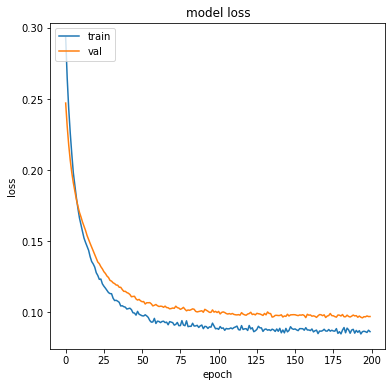

Val Cosine Similarity: 0.6499196436322556


In [0]:
# Run it to obtain reproducible results across machines (from keras.io)
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(12345)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

adam=tf.keras.optimizers.Adam(learning_rate=0.001)

grid_model_ensemble(df,df_test_ensemble,hidden_nodes=4,
                    dropout=0.05,l2_regularizer=0.02,
                    act='relu',optimizer=adam,epochs=200)

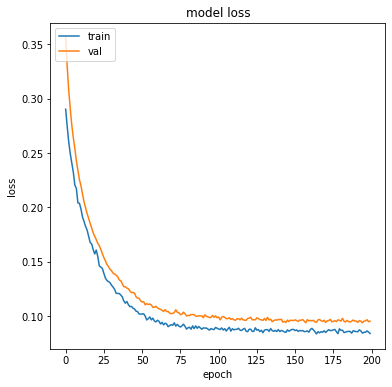

Val Cosine Similarity: 0.6548915051150876


In [0]:
# Run it to obtain reproducible results across machines (from keras.io)
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(12345)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

adam=tf.keras.optimizers.Adam(learning_rate=0.001)

grid_model_ensemble(df,df_test_ensemble,hidden_nodes=4,
                    dropout=0.05,l2_regularizer=0.03,
                    act='relu',optimizer=adam,epochs=200)

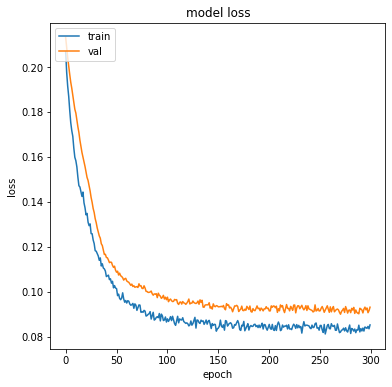

Val Cosine Similarity: 0.6618393985395585


In [0]:
# Run it to obtain reproducible results across machines (from keras.io)
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(12345)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

adam=tf.keras.optimizers.Adam(learning_rate=0.00075)

grid_model_ensemble(df,df_test_ensemble,hidden_nodes=4,
                    dropout=0.05,l2_regularizer=0.02,
                    act='relu',optimizer=adam,epochs=300)

final_model.save("gdrive/My Drive/TA/Seminar 1/Jupyter Notebook/model_Ensemble.h5")

## Final Model

In [0]:
# Run it to obtain reproducible results across machines (from keras.io)
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(12345)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

adam=tf.keras.optimizers.Adam(learning_rate=0.00075)

final_model=model_ensemble(df_full_ensemble,hidden_nodes=4,
                    dropout=0.05,l2_regularizer=0.02,
                    act='relu',optimizer=adam,epochs=300)

final_model.save("gdrive/My Drive/TA/Seminar 1/Jupyter Notebook/model_Ensemble.h5")

# Plot Model

In [0]:
def plot(model):
  '''
  Function for plot model
  '''
  K.clear_session()
  if model.lower()=='ensemble':
    model=Sequential()
    model.add(Dropout(0.05, input_shape=(4,)))
    model.add(Dense(4,kernel_regularizer=regularizers.l2(0.02),activity_regularizer=regularizers.l1(0.02)))
    model.add(Activation('relu'))
    model.add(Dense(1,activation='tanh'))
    plot_model(model, show_shapes=True,to_file='model_MLP_Ensemble.png')
    print('Done Plot Model Ensemble')

  elif model.lower()=='cnn_w2v':

    max_sequence_length=50
    embedding_layer = Embedding(30, 300, input_length=max_sequence_length, trainable=False) #30 is just a random number, because this number won't show in the plot
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    submodels=[]
    for kw in (1,2,3,4):    # kernel sizes
      embedded_sequences = embedding_layer(sequence_input)
      sub=GaussianNoise(0.01)(embedded_sequences)
      sub_submodels=[]
      for i in range(25):
        subsub=BatchNormalization()(sub)
        subsub=Conv1D(1,kw,padding='valid',activation='tanh',strides=1)(sub)
        subsub=GlobalMaxPooling1D()(subsub)
        subsubmodel=Model(sequence_input,subsub)
        sub_submodels.append(subsubmodel)
      sub_submodel_outputs=[subsubmodel.output for subsubmodel in sub_submodels]
      sub_out=Concatenate(axis=1)(sub_submodel_outputs)
      submodel=Model(sequence_input,sub_out)
      submodels.append(submodel)
    #Concatenate Multiple Filter Sizes
    submodel_outputs = [submodel.output for submodel in submodels]
    out = Concatenate(axis=1)(submodel_outputs)
    out = Dropout(0.45)(out)
    out = Dense(15,kernel_regularizer=regularizers.l2(0.008),activity_regularizer=regularizers.l1(0.008))(out)
    out=Activation('tanh')(out)
    out = Dense(15,kernel_regularizer=regularizers.l2(0.008),activity_regularizer=regularizers.l1(0.008))(out)
    out=Activation('tanh')(out)
    out = Dense(1)(out)
    big_model = Model(sequence_input,out)
    plot_model(big_model, show_shapes=True,to_file='model_CNN_W2V.png')
    print('Done Plot Model CNN W2V')

  elif model.lower()=='lstm_w2v':

    max_sequence_length=50
    embedding_layer = Embedding(30, 300, input_length=max_sequence_length, trainable=False) #30 is just a random number, because this number won't show in the plot
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    out=GaussianNoise(0.1)(embedded_sequences)
    out=tf.keras.layers.CuDNNLSTM(100,return_sequences=True)(out)
    out=tf.keras.layers.CuDNNLSTM(100)(out)
    out = Dropout(0.3)(out)
    out = Dense(50,kernel_regularizer=regularizers.l2(0.05),activity_regularizer=regularizers.l1(0.05))(out)
    out=Activation('relu')(out)
    out = Dense(10,kernel_regularizer=regularizers.l2(0.05),activity_regularizer=regularizers.l1(0.05))(out)
    out=Activation('tanh')(out)
    out = Dense(1)(out)
    model = Model(sequence_input,out)
    plot_model(model, show_shapes=True,to_file='model_LSTM_W2V.png')
    print('Done Plot Model LSTM W2V')
  
  elif model.lower()=='feature_driven':

    model = Sequential()
    model.add(Dropout(0.25, input_shape=(55,),seed=0))
    model.add(Dense(50,kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.01)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(30,kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.01)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(15,kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.01)))
    model.add(Activation('tanh'))
    model.add(Dense(1))
    plot_model(model, show_shapes=True,to_file='model_MLP_Feature_Driven.png')
    print('Done Plot Model MLP Feature Driven')
  
  elif model.lower()=='mlp_w2v':

    model = Sequential()
    model.add(Dropout(0.25, input_shape=(300,),seed=0))
    model.add(Dense(30,kernel_regularizer=regularizers.l2(0.004),activity_regularizer=regularizers.l1(0.004)))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(30,kernel_regularizer=regularizers.l2(0.004),activity_regularizer=regularizers.l1(0.004)))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(30,kernel_regularizer=regularizers.l2(0.004),activity_regularizer=regularizers.l1(0.004)))
    model.add(Activation('tanh'))
    model.add(Dense(1))
    plot_model(model, show_shapes=True,to_file='model_MLP_W2V.png')
    print('Done Plot Model MLP W2V')

In [0]:
for model in ['feature_driven','cnn_w2v','lstm_w2v','mlp_w2v','ensemble']:
  plot(model=model)

Done Plot Model MLP Feature Driven
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.540041 to fit

Done Plot Model CNN W2V
Done Plot Model LSTM W2V
Done Plot Model MLP W2V
Done Plot Model Ensemble
